#1) Download the  data

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kartik2112/fraud-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fraud-detection


In [2]:
import pandas as pd
import numpy as np

train = pd.read_csv('{0}/fraudTrain.csv'.format(path))
test = pd.read_csv('{0}/fraudTest.csv'.format(path))

#2a) Transform the data

1. Obtain the local time of day
  + account for local time zone
  + account for circularity of time with sine and cosine

2. Transform date of birth to age



In [3]:
#1) local transaction time

state_timezone_map = {
    'AL': 'America/Chicago',
    'AK': 'America/Anchorage',
    'AZ': 'America/Phoenix',       # No DST
    'AR': 'America/Chicago',
    'CA': 'America/Los_Angeles',
    'CO': 'America/Denver',
    'CT': 'America/New_York',
    'DE': 'America/New_York',
    'FL': 'America/New_York',      # Most of Florida
    'GA': 'America/New_York',
    'HI': 'Pacific/Honolulu',      # No DST
    'ID': 'America/Boise',         # Split between MT and PT
    'IL': 'America/Chicago',
    'IN': 'America/Indiana/Indianapolis',
    'IA': 'America/Chicago',
    'KS': 'America/Chicago',
    'KY': 'America/New_York',
    'LA': 'America/Chicago',
    'ME': 'America/New_York',
    'MD': 'America/New_York',
    'MA': 'America/New_York',
    'MI': 'America/Detroit',
    'MN': 'America/Chicago',
    'MS': 'America/Chicago',
    'MO': 'America/Chicago',
    'MT': 'America/Denver',
    'NE': 'America/Chicago',
    'NV': 'America/Los_Angeles',
    'NH': 'America/New_York',
    'NJ': 'America/New_York',
    'NM': 'America/Denver',
    'NY': 'America/New_York',
    'NC': 'America/New_York',
    'ND': 'America/Chicago',
    'OH': 'America/New_York',
    'OK': 'America/Chicago',
    'OR': 'America/Los_Angeles',
    'PA': 'America/New_York',
    'RI': 'America/New_York',
    'SC': 'America/New_York',
    'SD': 'America/Chicago',
    'TN': 'America/Chicago',
    'TX': 'America/Chicago',
    'UT': 'America/Denver',
    'VT': 'America/New_York',
    'VA': 'America/New_York',
    'WA': 'America/Los_Angeles',
    'WV': 'America/New_York',
    'WI': 'America/Chicago',
    'WY': 'America/Denver'
}

def local_time(df):
    df = df.copy()

    df['timezone'] = df['state'].map(state_timezone_map)
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['trans_date_trans_time'] = df['trans_date_trans_time'].dt.tz_localize('UTC')

    local_dt = df.apply(
        lambda row: row['trans_date_trans_time'].tz_convert(row['timezone']) if pd.notnull(row['timezone']) else pd.NaT,
        axis=1
    )

    time_in_seconds = local_dt.apply(
        lambda dt: dt.hour * 3600 + dt.minute * 60 + dt.second if pd.notnull(dt) else None
    )

    seconds_in_day = 24 * 60 * 60
    seconds_norm = time_in_seconds / seconds_in_day

    #acount for circularity of time of day
    ##i.e. 12:59pm is close to 1pm
    df['time_sin'] = np.sin(2 * np.pi * seconds_norm)
    df['time_cos'] = np.cos(2 * np.pi * seconds_norm)

    return df[['time_sin', 'time_cos']]


train[['time_sin', 'time_cos']] = local_time(train)
test[['time_sin', 'time_cos']] = local_time(test)

In [4]:
#2) Transform date of birth to age in years

def get_age(df):

    today = pd.Timestamp('2020-01-01')
    #could have reference 'today' be transaction time but doesn't matter much because transactions are all within two years

    df['dob'] = pd.to_datetime(df['dob'])
    df['age'] = df['dob'].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))

    return df['age']

train['age'] = get_age(train)
test['age'] = get_age(test)

#2b) Transform the data

###Use one-shot encoding for the two categorical features.

In [5]:
#columns to be removed
no_need = ['cc_num', 'Unnamed: 0','street', 'city',  'dob','job','first',
           'last','trans_num','trans_date_trans_time', 'lat', 'long', 'merch_lat',
           'merch_long', 'unix_time','merchant','state']


# Drop unnecessary columns
sparse_train = train.drop(columns=no_need)
sparse_test = test.drop(columns=no_need)

# Specify categorical columns to encode
categorical_columns = ['gender', 'category']

# Concatenate train and test temporarily to ensure consistent encoding
combined = pd.concat([sparse_train, sparse_test], keys=["train", "test"])

# One-hot encode the specified categorical columns
combined = pd.get_dummies(combined, columns=categorical_columns, drop_first=False)

# Split back into train and test
sparse_train = combined.xs("train")
sparse_test = combined.xs("test")

#setup features (X) and the classification (y)
y_train, X_train  = sparse_train['is_fraud'], sparse_train.drop(columns='is_fraud')
y_test, X_test = sparse_test['is_fraud'], sparse_test.drop(columns='is_fraud')

#3) Explore the data

In [6]:
print(sparse_train.columns)
print(sparse_train.dtypes)

N_observations, N_features = X_train.shape
print('Number of Observations: ' + str(N_observations))
print('Number of Features: ' + str(N_features))

#sparse_train.head()
#sparse_train.describe()

Index(['amt', 'zip', 'city_pop', 'is_fraud', 'time_sin', 'time_cos', 'age',
       'gender_F', 'gender_M', 'category_entertainment',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel'],
      dtype='object')
amt                        float64
zip                          int64
city_pop                     int64
is_fraud                     int64
time_sin                   float64
time_cos                   float64
age                          int64
gender_F                      bool
gender_M                      bool
category_entertainment        bool
category_food_dining          bool
category_gas_transport        bool
category_grocery_net          bool
category_grocery_pos          bool
category_health_fi

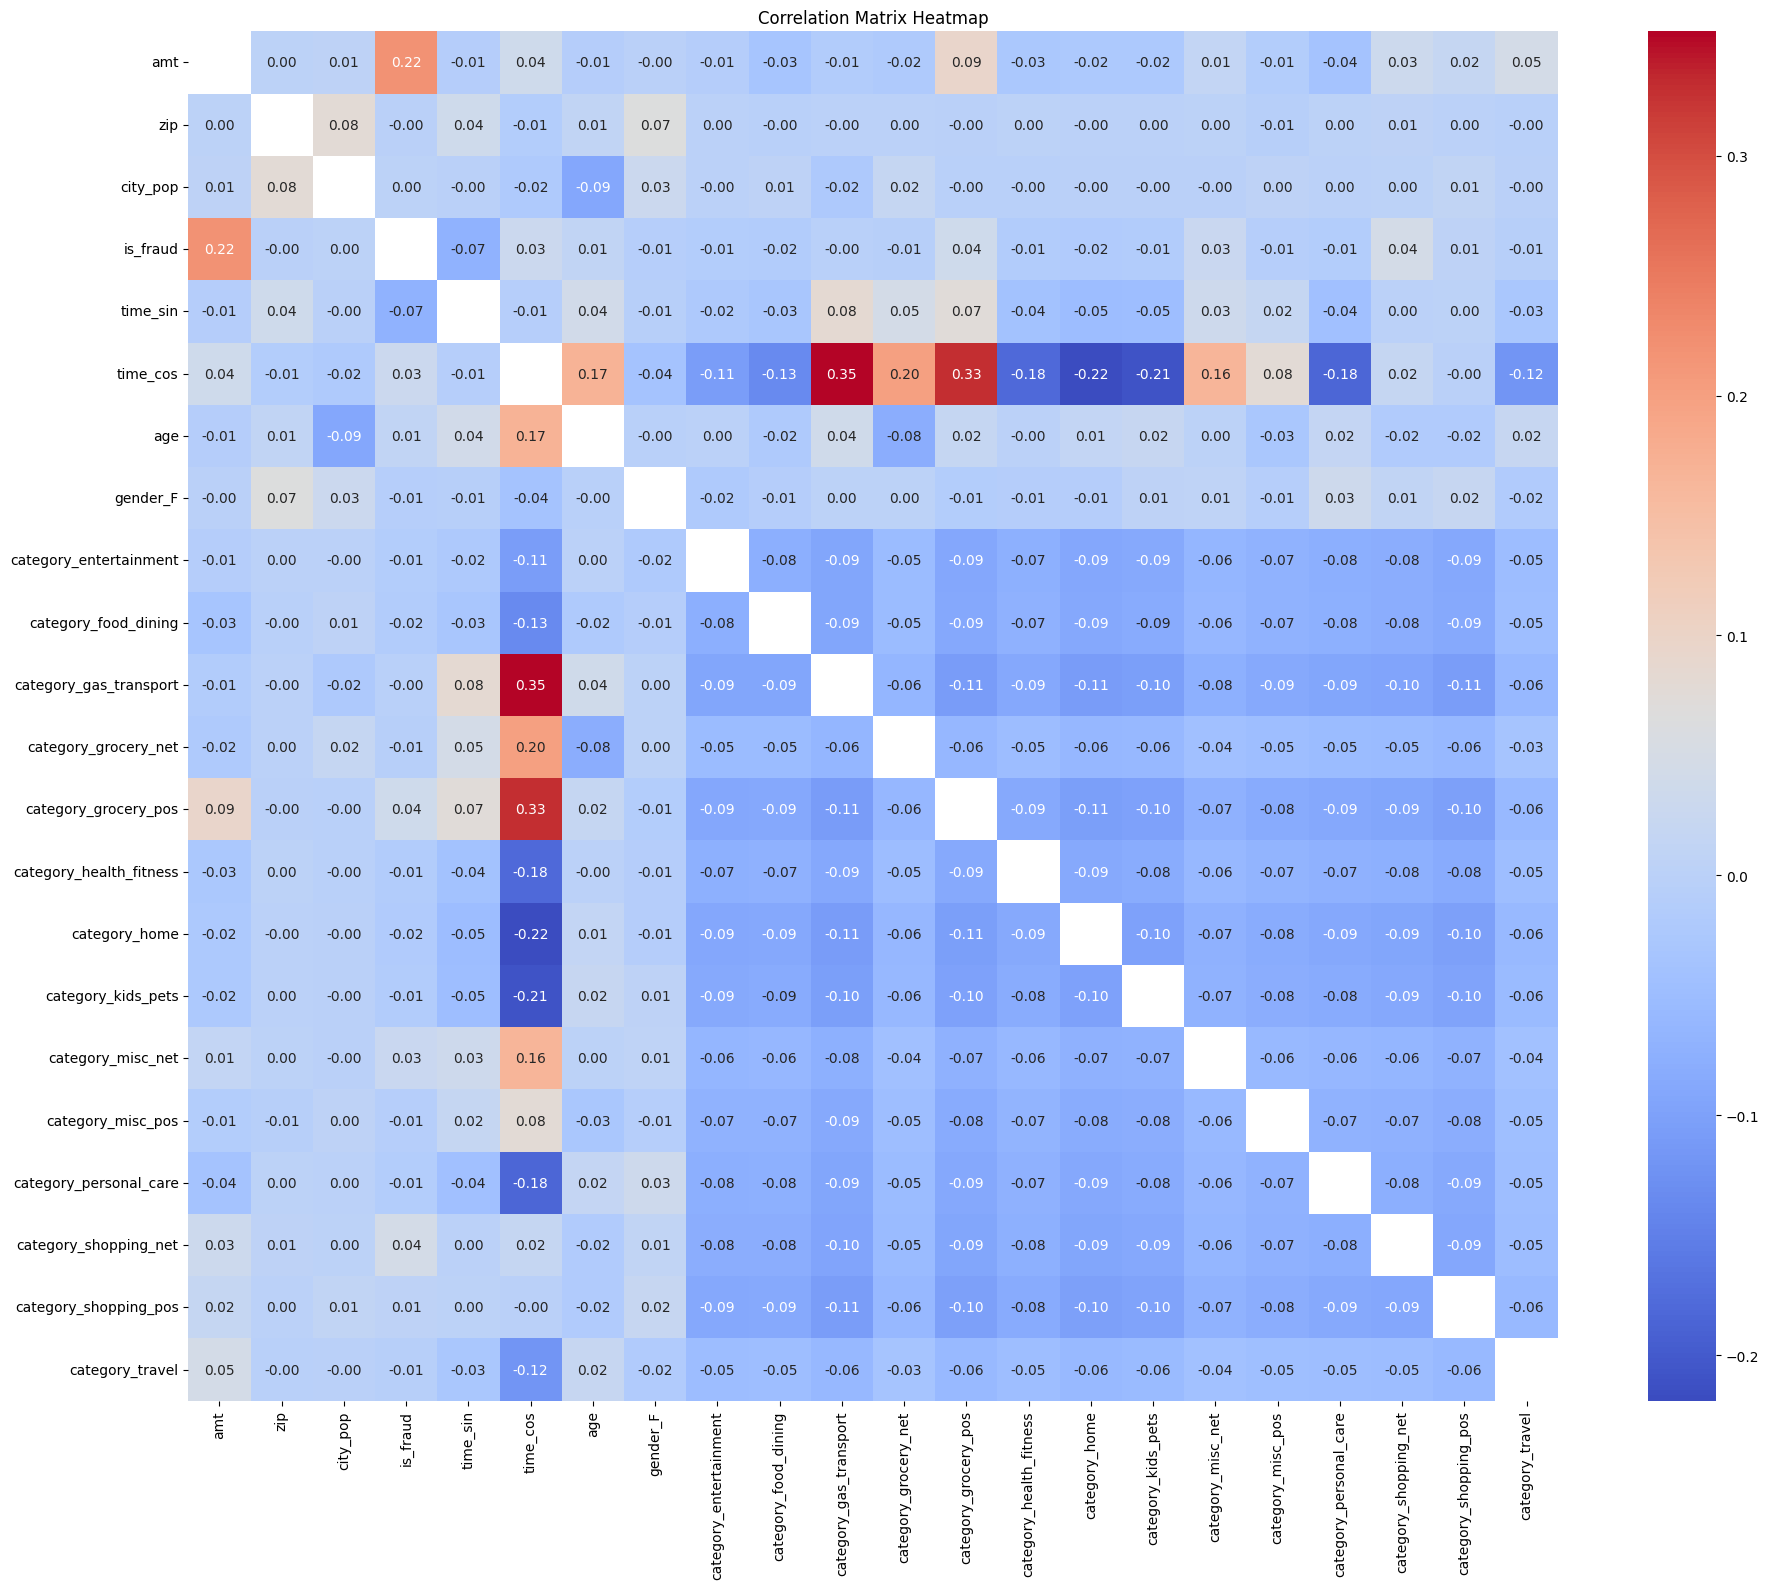

In [8]:
#Plot correlation matrix for numerical features

import matplotlib.pyplot as plt
import seaborn as sns

# Make one-shot coding into ints
numeric_df = sparse_train.fillna(0).astype(int)
numeric_df = sparse_train.drop(columns = 'gender_M')


# Compute correlation matrix
correlation_matrix = numeric_df.corr()
np.fill_diagonal(correlation_matrix.values, np.nan) #remove diagonal from consideration

plt.figure(figsize=(10*2, 8*2))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()


Fascinating that the time of day as measured by cosine so strongly correlates with what transaction category is bought.

Interesting that grocery_pos is the stongest correlate with fraud, however, when analyzing the SHAP values below, it does not seem that important. Shopping_pos is also the strongest correlate and indeed has the second highest SHAP value among all categories.

#4) Alright, time for some modeling!


In [13]:
#Use gpus to train XGB on the transformed data

from xgboost import XGBClassifier
from sklearn.metrics import classification_report


# Train XGBoost classifier
clf_xgb = XGBClassifier(device='cuda',tree_method='hist', eval_metric='logloss') #use gpu
clf_xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = clf_xgb.predict(X_test)

print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.89      0.74      0.80      2145

    accuracy                           1.00    555719
   macro avg       0.94      0.87      0.90    555719
weighted avg       1.00      1.00      1.00    555719



In [14]:
#Train XGB on transformed data.
#Reweight model to make fraud cases equal to non-fraud


#find reweight
counts = y_train.value_counts()
scale_pos_weight = counts.get(0,0)/counts.get(1,0)  #use this to upweight fraud cases


# Train XGBoost classifier
clf_xgb = XGBClassifier(device='cuda',tree_method='hist', eval_metric='logloss', scale_pos_weight=scale_pos_weight)
clf_xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = clf_xgb.predict(X_test)

print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00    553574
           1       0.27      0.93      0.42      2145

    accuracy                           0.99    555719
   macro avg       0.64      0.96      0.71    555719
weighted avg       1.00      0.99      0.99    555719



Intrestingly, one-shot encoding results are essentially unchanged from keeping feature as a categorical via the enable_categorical=True in XGBoost. For comparisons with models without enable_categorical parameter, we can still fairly judge XGBoost's performance.

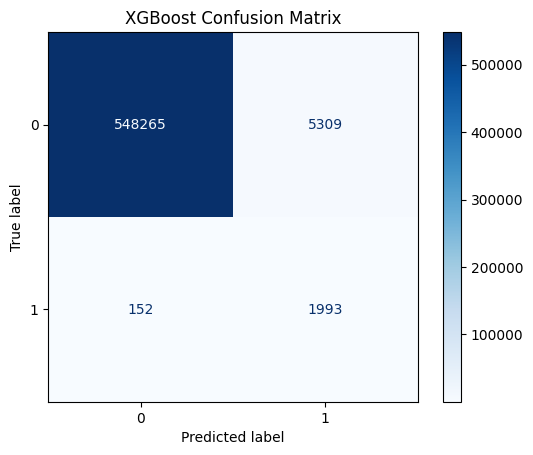

In [15]:
#Get greater granularity by plotting the confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("XGBoost Confusion Matrix")
plt.show()


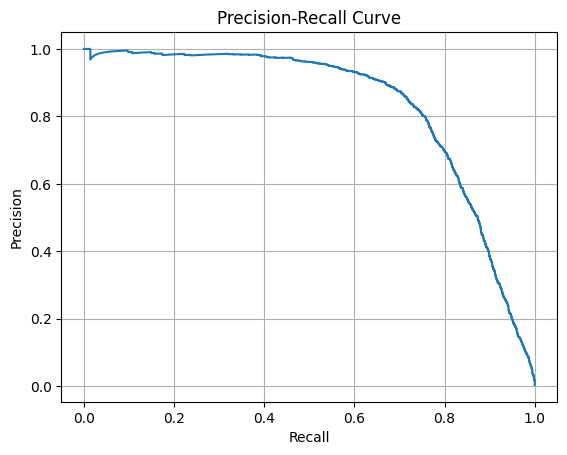

PR AUC: 0.8323
fraud rate: 0.0039
our model is 215.6x better than a random guesser.


In [16]:
#consider different thresholds (besides 0.5) to delineate fraud and legitimate transactions

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

y_prob = clf_xgb.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.show()
pr_auc = auc(recall, precision)

counts = y_test.value_counts()
fraud_rate = counts.get(1,0)/(counts.get(0,0)+counts.get(1,0))
print(f"PR AUC: {pr_auc:.4f}")
print("fraud rate: {:.4f}".format(fraud_rate))


print(f"our model is {pr_auc/fraud_rate:.1f}x better than a random guesser.")

#5) Interpret the model using Shap

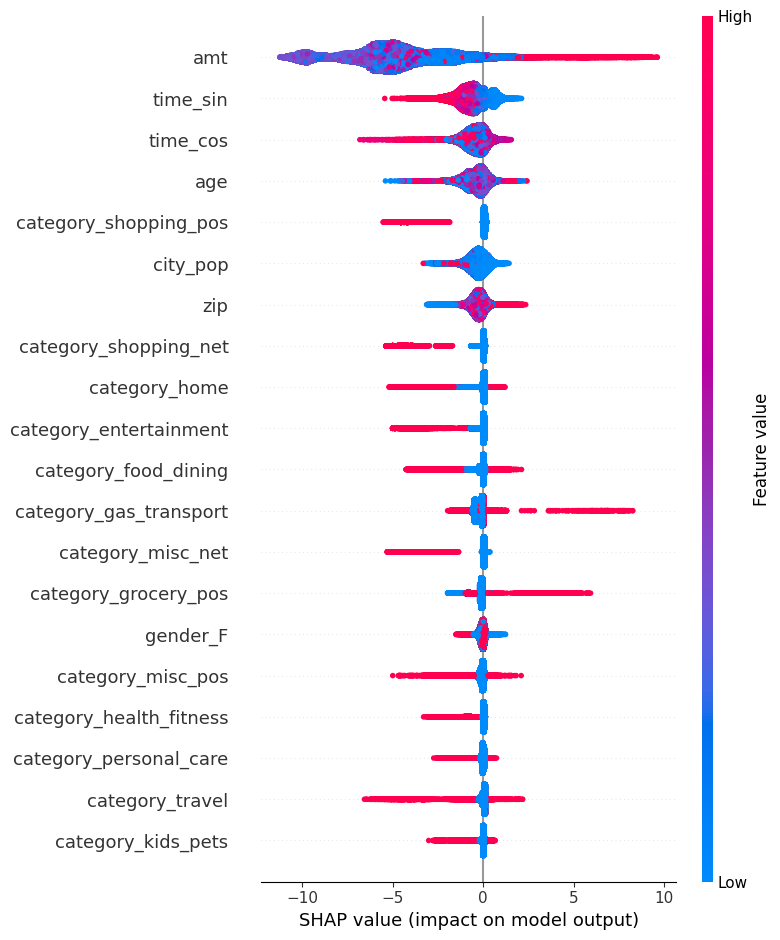

In [17]:
#Plot feature importance

import xgboost as xgb
import shap

# Get Booster object
booster = clf_xgb.get_booster()

# Convert input to DMatrix
dtest = xgb.DMatrix(X_test, enable_categorical=True)

# Get SHAP values (includes bias term as last column)
shap_values = booster.predict(dtest, pred_contribs=True)


# Remove the last column (bias term)
shap_values_no_bias = shap_values[:, :-1]

# Use the feature names from your training data (optional)
feature_names = X_test.columns.tolist()#[f"f{i}" for i in range(X_test.shape[1])]

# SHAP summary plot (dot)
shap.summary_plot(shap_values_no_bias, X_test, feature_names=feature_names)

Despite the aggregate category feature previously being the second most important, breaking category into its components makes each importance less than almost all other features.

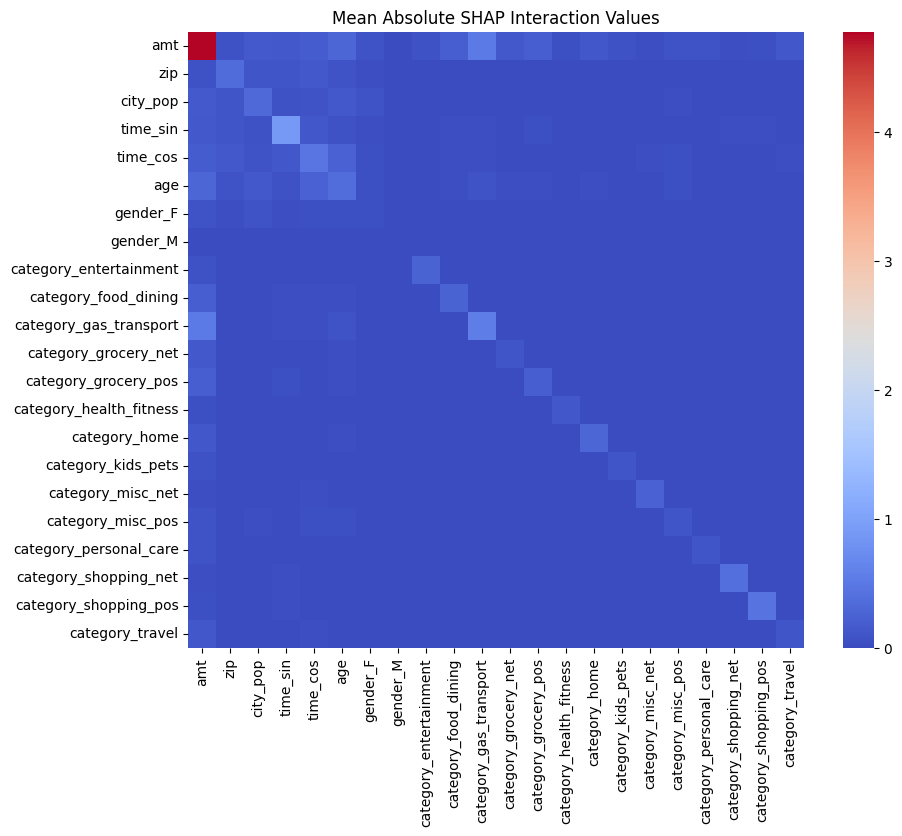

In [18]:
#Compare feature importance (diagonal) with respect to feature-feature interactions (off-diagonal)

# Get SHAP values (includes bias term as last column)
shap_intxn_values = booster.predict(dtest, pred_interactions=True)

# Remove the last column (bias term)
shap_intxn_values_no_bias = shap_intxn_values[:, :-1, :-1]

# Compute mean absolute interaction values across all samples
mean_abs_interactions = np.abs(shap_intxn_values_no_bias).mean(axis=0)

# Convert to DataFrame
df = pd.DataFrame(mean_abs_interactions, index=X_test.columns, columns=X_test.columns)

# Plot heatmap of interaction strengths
plt.figure(figsize=(10, 8))
sns.heatmap(df, cmap="coolwarm", square=True)
plt.title("Mean Absolute SHAP Interaction Values")
plt.show()